<img src="https://cdn.dal.ca/about-dal/history-tradition/logo-seal/_jcr_content/contentPar/staticimage.adaptive.full.high.png/1654529048363.png" alt="Dalogo" width="200"/>

# CSCI 4144 -  Data Mining and Data Warehousing
# Assignment 2 - Cube Computation

**Due:** 19 February 2024, anywhere on Earth

**Your name:** \[Arash Tashakori\]  


In [1]:
# import any libraries here
import pandas as pd
import numpy as np
import seaborn as sns


# TODO: add any additional libraries here
import matplotlib.pyplot as plt
# your code should run in Python3

/var/folders/6f/9psv00s129z5d9p39zmzxvyr0000gn/T/ipykernel_73675/1093348138.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Section 1 - Discretization

In this section, you will first minimally preprocess some data in order to make all inputs nominal.

### Dataset

Anti-democratic political movements, of various sizes, are springing up across many democratic nations, including Brazil. Your data is from the [Brazil Conflict Tracker](https://www.kaggle.com/datasets/justin2028/brazil-conflict-tracker-20182023). This is a dataset that tracks both non-violent and violent conflicts in Brazil since 2018. The 8 January 2023 invasion of Brazil's National Congress by Jair Bolsonaro supporters served as inspiration for this dataset. All data are official figures from the Armed Conflict Location & Event Data Project (ACLED) that have been compiled and structured by Justin Oh and released under the [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

The single file is in the [CSV](https://www.w3schools.com/python/pandas/pandas_csv.asp) file format, with a single header row and the several fields, including:

| Field                       | Type      | Description |
|-----------------------------|-----------|-------------|
|    EVENT_DATE | Date | The day, month and year on which a conflict event took place. |
|    EVENT_TYPE | Nominal | The type of conflict. |
|    SUB_EVENT_TYPE | Nominal | The type of sub-conflict.|
|    ACTOR1 | Nominal | The named actor in the conflict. |
|    ACTOR2 | Nominal | The named actor associated with or identifying ACTOR 1.|
|    COUNTRY | Nominal | The country in which the conflict took place (Brazil).|
|     LOCATION | Nominal | The specific location in which the conflict took place.|
|     LATITUDE | Real number | The latitude of the location.|
|     LONGITUDE | Real number | The longitude of the location.|
|    SOURCE_SCALE| Nominal| The scale (local, regional, national, international) of the source.|
|   NOTES | String | A short description of the conflict.|
|    FATALITIES | Integer | The number of reported fatalities that occurred during the conflict.|


### Tasks

First, some of the data (i.e., the precise location) is in the format of real numbers, which some of our subsequent computation will find difficult to handle.

Complete each of the code cells below according to the instructions in the comments. For each section, markers may take away marks for excessively poor quality code, at their discretion.



In [2]:
# 1. load the data in a Pandas DataFrame. 


try:
    brazilPoliViolenceDF = pd.read_csv("Brazil Political Violence and Protests Dataset.csv", index_col=0)
    print("The creation of the dataframe was successful.")
except Exception as exc:
    print(f"The following exception happened: {exc}")

The creation of the dataframe was successful.


In [3]:
# 2. Discretize the data.
#    Convert the each (latitude, longitude) pair into a discrete integer, 
#    which we can consider to be a nominal category. You will do this using two functions, 
#    both of which have the following inputs and output:
#        inputs:  'data': nx2 numpy array. The raw latitude and longitude columns from the original data,
#                                         in the original order.
#                 'H':    integer.         The number of bins of height/latitude, across the range of all latitudes
#                 'W':    integer.         The number of bins of width/longitude, across the range of all longitudes
#        
#        outputs: 'out':  list of ints.    The ith element is the index of the bin in the HxW grid, 
#                                         of the ith row in the given 'data', computed H first, e.g.:
#                                         | 0 | 3 | 6 |  9 |
#                                         | 1 | 4 | 7 | 10 |
#                                         | 2 | 5 | 8 | 11 |
#                                         for H=3 and W=4
#
#     First, use the 'equal width' method. See, e.g., Lecture 3, slide 40.
#     
def equalWidth( data:np.ndarray, H:int, W:int ):
    # this function uses the "equal width" way to put the data into bins, where the range of each bin is the same,
    # across each dimension independently
    
    out = []
    # TODO: your code goes here
    minLatitude = np.min(data[:, 0])
    maxLatitude = np.max(data[:, 0])
    minLongitude = np.min(data[:, 1])
    maxLongitude = np.max(data[:, 1])

    widthSizeForLatitude = (maxLatitude - minLatitude) / H
    widthSizeForLongitude = (maxLatitude - minLongitude) / W

    #Finding the index of the array in which the latitude and longitude fall under. The result is casted to int to
    #get the floor.
    for lat, long in data:
        indexInLatitudeBin = int ((lat - minLatitude) / widthSizeForLatitude)
        indexInLongitudeBin = int ((long - minLongitude) / widthSizeForLongitude)
    
        #If the latitude or longitude is an integer on the maximum edge of the bins, we have to decrease it by 1 because the
        #the bin indexes are from 0 to H-1 (or W-1) and in that case the data will go out of the bound of the number of bins
        if indexInLatitudeBin == H:
            indexInLatitudeBin = indexInLatitudeBin - 1
        if indexInLongitudeBin == W:
            indexInLongitudeBin = indexInLongitudeBin - 1
        
        indexOfBin = indexInLatitudeBin + (H * indexInLongitudeBin)
        

        out.append(indexOfBin)


    return out

In [4]:
# 3. Discretize the data with the 'equal depth' method
#    The same as above, but with the 'equal depth' method

#Find the index of a value in the given bin (For Equal Depth function)
def find_bin_index(value, bins):
    for index, bin in enumerate(bins):
        if value in bin:
            return index
    return -1  # Return -1 if the value is not in the bin

def equalDepth( data:np.ndarray, H:int, W:int ):
    # this function uses the 'equal depth' method of binning, where the number of elements in each bin
    # is approximately same. Given any remainder 'r' of N / (HxW), 'r' bins will have one more element 
    # than the rest.
    out = []
    
    #Sorting the arrays of lat and long and dividing them into their respective number of bins to be able to divide them
    #into bins of equal size
    latListSorted = np.sort(data[:, 0])
    longListSorted = np.sort(data[:, 1])
    latListSortedSize = len(latListSorted) // H
    longListSortedSize = len(longListSorted) // W

    #Dividing the lat and long data into bins of equal size (Except possibly for the last bin that can be different)
    latEqDepBins = []
    for i in range (H):
        startIndex = i * latListSortedSize
        endIndex = (i + 1) * latListSortedSize if i < H - 1 else len(latListSorted)
        latEqDepBins.append(latListSorted[startIndex:endIndex]) 

    longEqDepBins = []
    for i in range (W):
        startIndex = i * longListSortedSize
        endIndex = (i + 1) * longListSortedSize if i < W - 1 else len(longListSorted)
        longEqDepBins.append(longListSorted[startIndex:endIndex]) 


    #Putting the lat and long indices and putting them into the output sorted in the format that the problem requires
        #(Putting them into a single dimentional array of integers, with each row within the same H coming before
        #the rows of the next H
    for lat, long in data:
        latBinIndex = find_bin_index(lat, latEqDepBins)
        longBinIndex = find_bin_index(long, longEqDepBins)
        indexOfBin = latBinIndex + (H * longBinIndex)
        out.append (indexOfBin)
    
    return out

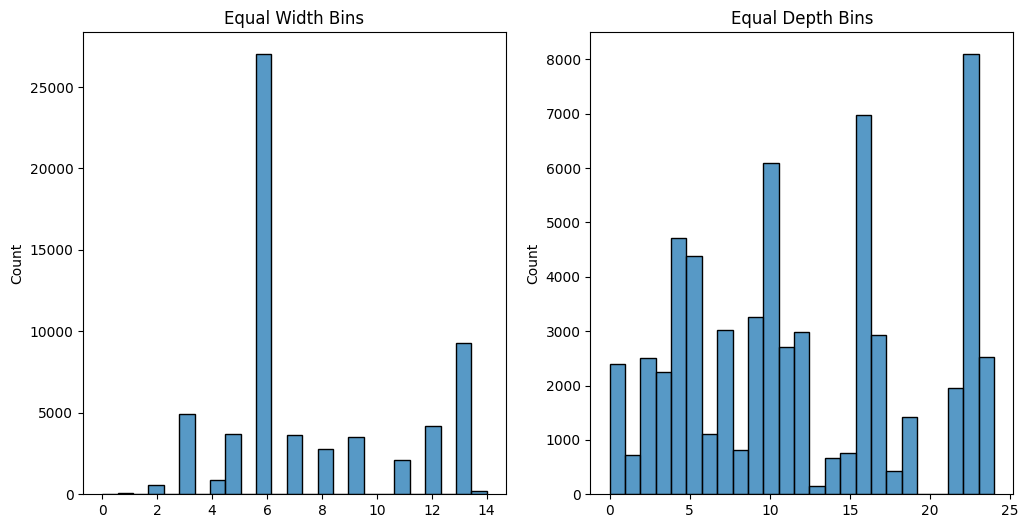

In [5]:
# 4. Plot the discretized data.

latAndLongData = brazilPoliViolenceDF[["LATITUDE", "LONGITUDE"]].to_numpy()
eqWidthBins = equalWidth(latAndLongData, H=5, W=5)
eqDepthBins = equalDepth(latAndLongData, H=5, W=5)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(eqWidthBins, bins=25, kde=False)
plt.title("Equal Width Bins")

plt.subplot(1, 2, 2)
sns.histplot(eqDepthBins, bins=25, kde=False)
plt.title("Equal Depth Bins")

plt.show()

## Section 2 - Bottom-up computation

Here, you will code the 'bottom-up computation' method described in class (i.e., Lecture 5, Slides 45-54). In particular, you have pseudocode (in Lecture 5, Slides 50-51) and extra detail at these locations:

- The original paper (in this course's [BrightSpace](https://dal.brightspace.com/d2l/le/content/250788/viewContent/3515315/View))
- In this University of Regina [tutorial](http://www2.cs.uregina.ca/~dbd/cs831/notes/dcubes/iceberg.html)

Unfortunately, the code provided by the paper may be confusing with regards to how we actually *write* the records we approve (and, technically, there appears to be an error in their pseudocode). For simplicity, we will modify the BUC algorithm from Lecture 5 (Slide 55), with the crossed out bits removed in two ways:

1. We will have a new parameter, `curState` which is an $n$-dimensional list of strings representing the current cell state, where '\*' is aggregate, of the current level of abstraction of the call. 
    1. I.e., the first call to BUC(...) is the apex, so the list would be ['\*','\*',...,'\*'].
    2. Every recursive call to BUC(...) will update this list to add specificity to the list. I.e., if the current value for dimension 1 is 'aaa', then you would call BUC(...) with `curState` = ['aaa','\*',...,'\*']
2. Once you have returned from the recursive call to BUC(...), i.e., line 12 in the pseudocode, you should append your new augmented `curState` to the global output record, `outputRec`. 
    1. Note that his should be a string in the format of (Lec 5, Slide 9-10), i.e., '(a_1, a_2, ..., a_n):m' where, again, aggregate dimensions are just '*' without quotes and `a_i` is the literal dimension label.


Complete each of the code cells below according to the instructions in the comments. For each section, markers may take away marks for excessively poor quality code, at their discretion.

In [6]:
# 1. PREPARE data for using BUC
#       1) REMOVE the following dimensions from the original data:
#              - EVENT_DATE
#              - SUB_EVENT_TYPE
#              - ACTOR2
#              - COUNTRY
#              - LOCATION
#              - NOTES

#Resetting the indexes because EVENT_DATE is set by default as the primary column and cannot be removed without resetting
brazilPoliViolenceDF.reset_index(inplace = True)
brazilPoliViolenceDF = brazilPoliViolenceDF.drop(columns = ["EVENT_DATE", "SUB_EVENT_TYPE", "ACTOR2", "COUNTRY", "LOCATION",
                                                 "NOTES"])




#       2) REPLACE the LATITUDE and LONGITUDE dimensions in the original data
#          with a new dimension, 'LOC', consisting of the integers produced by your
#          equalWidth() function, above, using H=5 and W=5
#          Your dimensions are now:
#             0: EVENT_TYPE
#             1: ACTOR1
#             2: LOC
#             3: SOURCE_SCALE
#             4: FATALITIES

numDims = 5

#Make the new column LOC
latAndLongData = brazilPoliViolenceDF[["LATITUDE", "LONGITUDE"]].to_numpy()
brazilPoliViolenceDF['LOC'] = equalWidth(latAndLongData, H=numDims, W=numDims)

#Remove lat and long
brazilPoliViolenceDF = brazilPoliViolenceDF.drop(columns=["LATITUDE", "LONGITUDE"])

brazilPoliViolenceDF = brazilPoliViolenceDF.sort_values(by=["EVENT_TYPE", "ACTOR1", "LOC", "SOURCE_SCALE", "FATALITIES"])



#       3) FILL the list 'card' with the cardinalities (number of unique elements)
#          in each dimension, indexed as above.
# TODO: your code goes here
card = []

for col in brazilPoliViolenceDF.columns:
    #We can turn each column in the DF to a set (Have only unique values) and count them using len 
    valueSet = set(brazilPoliViolenceDF[col])
    noOfUniqueValuesPerCol = len(valueSet)
    card.append(noOfUniqueValuesPerCol)

print("Cardinalities: " + str(card))

dataCount = []

for col in brazilPoliViolenceDF.columns:
    # Sorting the unique values of each of the columns of the dataframe and storing them
    uniqueValuesList = sorted(list(set(brazilPoliViolenceDF[col])))
    #Creating a variable to count the unique variables
    countUniqueValuesList = [0] * len(uniqueValuesList)
    
    # Count the number of each of those unique values found in the dataframe
    for value in uniqueValuesList:
        count = 0

        for data_point in brazilPoliViolenceDF[col]:
            if data_point == value:
                count = count + 1

        countUniqueValuesList[uniqueValuesList.index(value)] = count
    
    dataCount.append(countUniqueValuesList)
    
print("dataCount: " + str(dataCount))

outputRec = []

Cardinalities: [6, 134, 17, 24, 14]
dataCount: [[20392, 573, 20210, 3472, 2316, 15898], [1, 54, 1, 1, 1, 1, 9, 9, 1, 1, 20, 1, 3, 4, 1, 1, 2, 4, 9, 1, 944, 2, 9, 1, 1, 3, 1, 1, 1, 1, 32, 1, 1, 21, 2, 1, 2, 8, 1, 6, 2, 1, 5, 2, 5, 1, 2, 40, 1055, 50, 17, 4936, 117, 4, 53, 1, 1, 2, 5, 1, 361, 3, 6, 2, 8, 2, 1, 1, 1, 1, 1, 3, 1, 5, 151, 155, 138, 3, 10, 11, 326, 649, 589, 5, 40, 36, 7, 3, 1, 1, 1, 1, 24, 1, 1, 26, 27, 20167, 1, 1, 1, 1, 1, 3, 8, 2, 4, 2, 3468, 3, 1, 303, 1, 20, 1, 1, 2, 4, 2, 1, 1, 1, 10628, 2, 4, 7, 10, 5552, 4, 12564, 1, 1, 1, 21], [117, 4, 29, 33487, 46, 7146, 2, 245, 666, 77, 14, 1, 3, 5, 18587, 32, 2400], [40709, 18101, 2770, 783, 279, 106, 37, 23, 21, 7, 2, 3, 3, 2, 4, 1, 2, 1, 1, 2, 1, 1, 1, 1], [1, 75, 572, 4911, 886, 3711, 27005, 3661, 2779, 3497, 2098, 4182, 9281, 202]]


In [7]:
# 2. Code the recursive BUC function 
#        inputs:  'input':     pandas df      Previously sorted data (see above).
#                 'curState':  list of str    The current state, as described above
#                 'dim':       integer.       The starting dimension for this iteration
#        globals: 'numDims':   integer.       The total number of dimensions
#                 'card':      list of ints.  Where card[d] is the cardinality of dimension d
#                 'minSup':    integer.       The minimum support
#                 'dataCount': list of lists. dataCount[d] is a list of integers, each of size card[d]
#                                             dataCount[d][i] is the size of a partition for variable 'i'
#        output:  

def BUC( input, curState, dim:int ):   
    global minSup, numDims, dataCount

    # if we've reached the last dimension output the current state if it is over the threshold
    if dim == numDims:
        # Count the number of tuples in the partition that we are currently on in the loop
        count = input.shape[0]
        if count >= minSup: #If it's over the threshold attach a pair of current state and its count to outputRec
            outputRec.append(f"({', '.join(curState)}): {count}")
        return  #Controller case for the recurssion 

    # Going through the values on the dimension (dim) that we are currently on in this instance of the recurssion
    for i in range(card[dim]):
        # Focus on one value by copying the current state and filter the input for that value
        updateState = curState.copy()
        updateState[dim] = input.columns[dim] + '=' + str(i)

        # Filter the input data for the current value
        currentCol = input.columns[dim]
        filter = input[currentCol] == i
        filteredInputForCurrVal = input[filter]

        # If the partition meets the minSup requirement we call our function recursively for the next dimension
        if dataCount[dim][i] >= minSup:
            BUC (filteredInputForCurrVal, updateState, dim + 1)

    # Dealing with the aggrevation over all combos of the values in this dimension
    updateState = curState.copy()
    updateState[dim] = '*'    #Aggrevating the value of the current dimension to pass on to the next recursive call
    BUC (input, updateState, dim + 1)

# test outputRec
minSup = 5
curState = ['*'] * numDims
BUC (brazilPoliViolenceDF, curState, 0)
print (outputRec)

#When appending to outputRec, we can also do outputRec.append((curState, count)) for easier manipulation
#if we want to work with it later but I chose that format one to best resemble the examples on slides 5-8 from Lecture 5

['(*, *, *, FATALITIES=0, LOC=1): 54', '(*, *, *, FATALITIES=0, LOC=2): 333', '(*, *, *, FATALITIES=0, LOC=3): 2176', '(*, *, *, FATALITIES=0, LOC=4): 494', '(*, *, *, FATALITIES=0, LOC=5): 2664', '(*, *, *, FATALITIES=0, LOC=6): 20874', '(*, *, *, FATALITIES=0, LOC=7): 2442', '(*, *, *, FATALITIES=0, LOC=8): 1429', '(*, *, *, FATALITIES=0, LOC=9): 1595', '(*, *, *, FATALITIES=0, LOC=11): 1379', '(*, *, *, FATALITIES=0, LOC=12): 2189', '(*, *, *, FATALITIES=0, LOC=13): 5009', '(*, *, *, FATALITIES=0, *): 40709', '(*, *, *, FATALITIES=1, LOC=1): 20', '(*, *, *, FATALITIES=1, LOC=2): 201', '(*, *, *, FATALITIES=1, LOC=3): 2361', '(*, *, *, FATALITIES=1, LOC=4): 349', '(*, *, *, FATALITIES=1, LOC=5): 783', '(*, *, *, FATALITIES=1, LOC=6): 4841', '(*, *, *, FATALITIES=1, LOC=7): 994', '(*, *, *, FATALITIES=1, LOC=8): 1184', '(*, *, *, FATALITIES=1, LOC=9): 1662', '(*, *, *, FATALITIES=1, LOC=11): 602', '(*, *, *, FATALITIES=1, LOC=12): 1452', '(*, *, *, FATALITIES=1, LOC=13): 3533', '(*, *

In [8]:
# 3. Run the computation of the BUC function
#    run it once with minSup = 10 and once with minSup = 5
#    print the number of elements in `outputRec` in each case, 

minSup = 10

# TODO: your code goes here
curState = ['*'] * numDims
BUC(brazilPoliViolenceDF, curState, 0)
print(f"number of elements in outputRec with minSup = 10: {len(outputRec)}")

outputRec = []
minSup = 5

# TODO: your code goes here

curState = ['*'] * numDims
BUC(brazilPoliViolenceDF, curState, 0)
print(f"number of elements in outputRec with minSup = 5: {len(outputRec)}")

number of elements in outputRec with minSup = 10: 164
number of elements in outputRec with minSup = 5: 87
